# 🩺 Maternal Health Risk Prediction
This notebook builds a machine learning model to classify maternal health risk into **Low**, **Mid**, or **High Risk** using the UCI Maternal Health Risk dataset.

---

## 📦 Import Libraries

In [3]:
import pandas as pd
import numpy as np

## 📂 Load and Inspect Dataset

In [4]:
df = pd.read_csv("/content/Maternal Health Risk Data Set (1).csv")

In [5]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [6]:
df.isnull().sum()

,0
Age,0
SystolicBP,0
DiastolicBP,0
BS,0
BodyTemp,0
HeartRate,0
RiskLevel,0


## 🧹 Data Preprocessing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
encoder = LabelEncoder()

In [9]:
df["RiskLevel"] = encoder.fit_transform(df["RiskLevel"])

Low Risk = 1
Mid Risk = 2
High Risk = 0

In [10]:
X = df.drop(columns=["RiskLevel"])
y = df["RiskLevel"]

## 🤖 Model Training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from xgboost import XGBClassifier

In [13]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class = 3,
    max_depth=3,
    learning_rate = 0.1,
    eval_metric = 'mlogloss',
    use_label_encoder = False
)

In [14]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [15]:
y_pred = model.predict(X_test)

## 📈 Model Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

   high risk       0.86      0.81      0.84        47
    low risk       0.70      0.78      0.73        80
    mid risk       0.70      0.64      0.67        76

    accuracy                           0.73       203
   macro avg       0.75      0.74      0.75       203
weighted avg       0.74      0.73      0.73       203



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

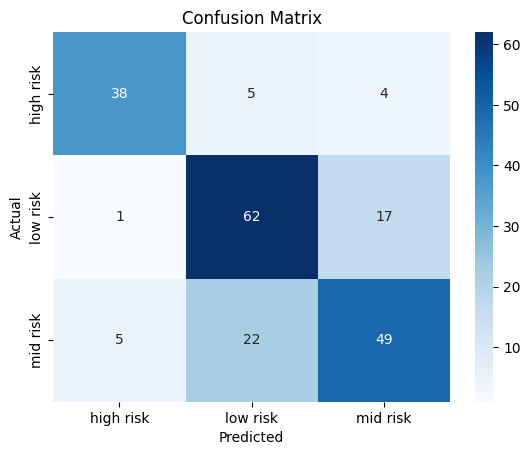

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 🧠 Feature Importance

In [20]:
importances = model.feature_importances_
feat_names = X.columns
sorted_idx = np.argsort(importances)

In [21]:
for i in sorted_idx:
    print(f"{feat_names[i]}: {importances[i]}")

HeartRate: 0.06529923528432846
DiastolicBP: 0.07102058827877045
Age: 0.07857345044612885
BodyTemp: 0.1823318600654602
SystolicBP: 0.25804221630096436
BS: 0.3447325825691223


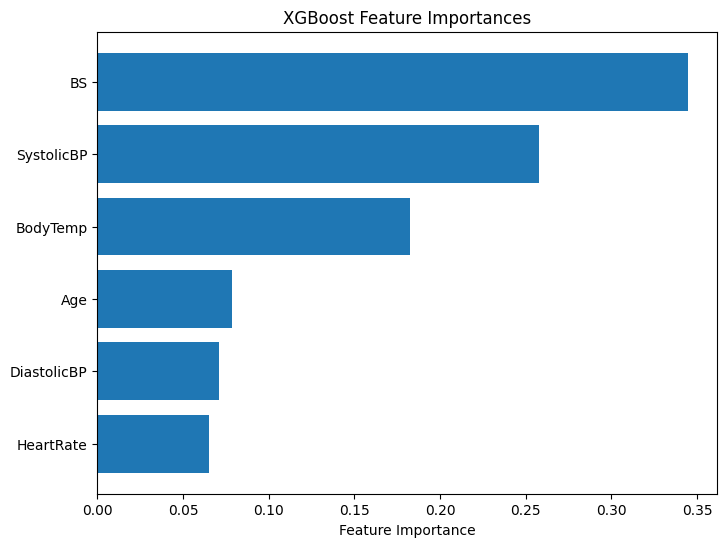

In [22]:
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(np.arange(len(sorted_idx)), [feat_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()

Dropping low importance features, handling class imbalance and retraining

## 🧹 Data Preprocessing

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
important_features = ["BS", "SystolicBP", "BodyTemp", "Age"]

In [25]:
X_filtered = X[important_features]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

In [27]:
smote = SMOTE(random_state = 42)

In [28]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## 🤖 Model Training on balanced dataset with important features using Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [31]:
classifier.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [32]:
y_pred = classifier.predict(X_test)

## 📈 Model Evaluation

In [33]:
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

   high risk       0.85      0.85      0.85        47
    low risk       0.82      0.79      0.80        80
    mid risk       0.76      0.79      0.77        76

    accuracy                           0.80       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.80      0.80      0.80       203



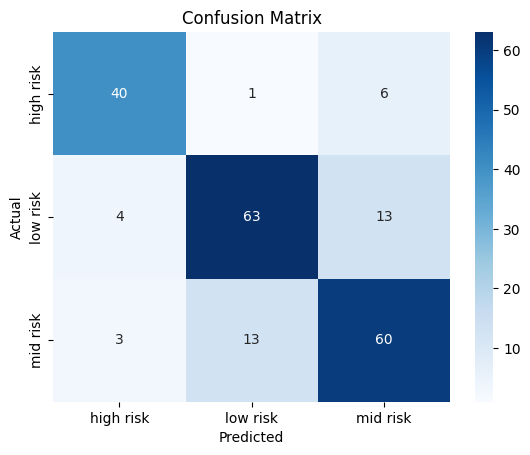

In [34]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 🤖 Model Retraining and Evaluation with XGBoost

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_resampled, y_resampled)
y_pred_xgb = xgb.predict(X_test)

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.82      0.82      0.82        80
           2       0.80      0.79      0.79        76

    accuracy                           0.82       203
   macro avg       0.83      0.83      0.83       203
weighted avg       0.82      0.82      0.82       203

Confusion Matrix (XGBoost):
[[41  1  5]
 [ 4 66 10]
 [ 3 13 60]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
import joblib

joblib.dump(xgb, 'xgb_maternal_predictor.pkl')

['xgb_maternal_predictor.pkl']

## ✅ Conclusion
The XGBoost model achieved an **accuracy of 82%** and a **macro F1-score of 0.83**, making it suitable for a production-ready maternal health risk prediction system.